In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import warnings
import chainladder as cl # Sparse=0.14.0 ; incremental.py np.NINF -> -np.inf
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [22]:
def claims_formatter(doc:pd.DataFrame):
    doc_copy = doc.copy()
    
    #Acomodo indice
    doc_copy.index = doc_copy.AUTOMOTORES
    formatted_doc = doc_copy.iloc[:,4:].stack(level = [0,1,2,3]).reset_index([1,2,3,4]).drop_duplicates()
    formatted_doc.reset_index(inplace = True)
    formatted_doc[['Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']] = pd.DataFrame(formatted_doc[('index','')].to_list(), index = formatted_doc.index)

    #Acomodo columnas
    formatted_doc.columns = ['indice','Tipo', 'Periodo', 'Desarrollo 1', 'Año Valuacion', 'Pendientes', 'Pagados', 'Incurridos', 'Cantidad', 'Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']
    formatted_doc['Año Ocurrencia'] = pd.to_datetime(formatted_doc['Periodo'][0][0:5]) + pd.DateOffset(months = 6)
    formatted_doc['Año Valuacion'] = pd.to_datetime(formatted_doc['Año Valuacion'])
    #formatted_doc['Desarrollo'] = formatted_doc['Año Valuacion'] - formatted_doc['Año Ocurrencia']
    formatted_doc.drop(['indice','Tipo', 'Periodo', 'Desarrollo 1'], axis = 1, inplace = True)

    return formatted_doc

def check_chainladder_assumptions( triangle:cl.Triangle, columns:list):
    for column in columns:
        if triangle[column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
            print(f'Triangulo {column}: Años de valuación correlacionados')
        elif triangle[column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
            print(f'Triangulo {column}: Años de desarrollo no correlacionados')
    return 0

def rgaa_chainladder(triang_stos_act:cl.Triangle):

    #Valores Actuales
    latest_diag = triang_stos_act['Incurridos'].incr_to_cum().latest_diagonal.to_frame()  

    #Modelo CL
    pipe_rgaa = cl.Pipeline(steps=[
        ("development", cl.Development(average="volume")),
        ("tail", cl.TailConstant(tail=1.05, decay = 1)),
        ('cl_model', cl.Chainladder() ),    
    ])

    triang_rgaa = pipe_rgaa.fit(triang_stos_act['Incurridos'].incr_to_cum())

    #CDFs & Ultimate
    cl_triang = triang_rgaa.named_steps.cl_model.full_triangle_.to_frame()
    cl_cdfs = triang_rgaa.named_steps.cl_model.cdf_.to_frame().melt()

    cl_ultimate = cl_triang.iloc[:,len(cl_triang.columns)-1]
    cl_cdfs = cl_cdfs[len(cl_cdfs)-2::-1].set_index(latest_diag.index, drop = True )

    #Concateno todo
    result = pd.concat([latest_diag, cl_cdfs['value'], cl_ultimate], axis = 1)
    result.columns = ['Actual', 'FDA', 'Ultimate']
    result['IBNR'] = result['Ultimate'] - result['Actual']

    return result
            

In [23]:
import os
os.getcwd()

'c:\\Users\\Alex\\Documents\\Python Script\\Github\\IBNR-NIIF-17'

In [24]:
sto_input = pd.read_excel('sample\\ssn_20232024_desarrollo_siniestros_automotores.xlsX', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel('sample\\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if (k[0] == '2') or (k[0] == '1')]
db_stos = pd.concat(sto_input_formateado)

In [25]:
sto_input = pd.read_excel('sample\\ssn_20232024_desarrollo_siniestros_automotores.xlsX', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel('sample\\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if (k[0] == '2') or (k[0] == '1')]
db_stos = pd.concat(sto_input_formateado)

#Tratamiento indice facpce
db_facpce = facpce_input.set_index('MES')
#factores_facpce = db_facpce.loc[max(db_stos['Año Valuacion']) - pd.DateOffset(days = 29)] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 5, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
factores_facpce = db_facpce.loc[pd.Timestamp('2024-06-01 00:00:00')] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 0, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
db_stos['Factor FACPSE'] = factores_facpce.set_index(db_stos.index)

#Armo el dataframe para el triángulo que quiero analizar 
idx = (db_stos['Base Origen'] == '[HG]') & (db_stos['Ramo'].str.contains('RC ', na=False))
db_triangle = db_stos.loc[idx, ['Año Ocurrencia', 'Año Valuacion', 'Pendientes','Pagados' , 'Incurridos', 'Factor FACPSE', 'Cantidad', 'Ramo']]
db_triangle['Año Valuacion'] = db_triangle['Año Valuacion'] + pd.DateOffset(months = -6)
db_triangle['Año Ocurrencia'] = db_triangle['Año Ocurrencia'] + pd.DateOffset(months = -6)

#Chequeo supuestos para Cl y aplico el factor FACPCE
triang_stos = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = ['Pagados', 'Pendientes', 'Incurridos', 'Cantidad'], index=['Ramo'], cumulative = True)
triang_facpce = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = 'Factor FACPSE', index = ['Ramo'])
triang_stos_act = triang_stos.cum_to_incr() * triang_facpce
#check_chainladder_assumptions(triang_stos_act, ['Pagados', 'Pendientes', 'Incurridos'])

In [26]:
# ramos = ['RC daños a cosas', 'RC lesiones 3º no transportados',
#        'RC lesiones 3º transportados']
# ramo = ramos[2]
# for i in range(3):
#     (triang_stos/1000000000).iloc[i,0].to_frame().to_excel(f'Resultados\\tri_facpce_rgaa_{ramos[i]}.xlsx')
#     triang_facpce.iloc[i,0].to_frame().to_excel(f'Resultados\\facpce_rgaa_{ramos[i]}.xlsx')
    

In [27]:
#RGAA
pipe_rgaa = cl.Pipeline(steps=[
    ("development", cl.Development(average="volume")),
    ("tail", cl.TailConstant(tail=1.05, decay = 0, projection_period = 0)),
    ('model', cl.Chainladder() )])

triang_rgaa = pipe_rgaa.fit(triang_stos_act['Incurridos'].incr_to_cum())
rgaa_ibnr = triang_rgaa.named_steps.model.ibnr_.to_frame().T

In [28]:
# ramos = ['RC daños a cosas', 'RC lesiones 3º no transportados',
#        'RC lesiones 3º transportados']
# ramo = ramos[2]
# for i in range(3):
#     triang_rgaa.named_steps.model.ldf_.iloc[i,0].to_frame().to_excel(f'Resultados\\ldf_rgaa_{ramos[i]}.xlsx')
#     (triang_rgaa.named_steps.model.X_.iloc[i,0]/1000000000).to_frame().to_excel(f'Resultados\\tri_rgaa_{ramos[i]}.xlsx')
#     (triang_rgaa.named_steps.model.ibnr_.iloc[i,0]/1000000000).to_frame().to_excel(f'Resultados\\ibnr_rgaa_{ramos[i]}.xlsx')
    

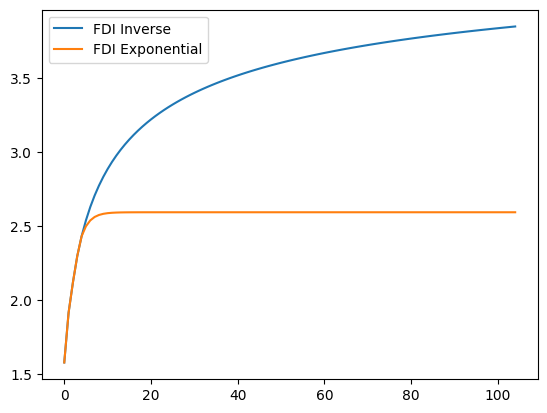

In [29]:
#Analisis de Extrapolación de cola

ramos = ['RC daños a cosas', 'RC lesiones 3º no transportados',
       'RC lesiones 3º transportados']
ramo = ramos[2]


tria = triang_stos_act[triang_stos_act['Ramo']==ramo]['Incurridos'].incr_to_cum()

dev = cl.Development().fit_transform(tria)
tail_inv = cl.TailCurve(curve='inverse_power').fit(dev)
tail_exp = cl.TailCurve(curve='exponential').fit(dev)
values_list = tail_inv.ldf_['Incurridos'].to_frame().values.flatten().tolist()

inv_power_tail = 1 + np.exp(tail_inv.intercept_.values) * (
        np.arange(
            tria.shape[-1], 
            tria.shape[-1] + tail_inv.extrap_periods
        ) ** tail_inv.slope_.values)

exp_power_tail = 1+np.exp(
        np.arange(tria.shape[-1],
                  tria.shape[-1] + tail_exp.extrap_periods) * 
        tail_exp.slope_.values + tail_exp.intercept_.values)

fdi_inv = values_list[:-2] + inv_power_tail.tolist()[0]
fdi_exp = values_list[:-2] + exp_power_tail.tolist()[0]


# Flatten the lists to ensure they are one-dimensional
fdi_inv_flat = np.cumprod(fdi_inv)
fdi_exp_flat = np.cumprod(fdi_exp)

# Plot the flattened arrays
plt.plot(fdi_inv_flat, label='FDI Inverse')
plt.plot(fdi_exp_flat, label='FDI Exponential')
plt.legend()
plt.show()

In [30]:
# #Validación Extrapolación de cola
# from scipy.stats import pearsonr

# tail_dict = pd.read_excel('Analisis extrapolación.xlsx', sheet_name = None)

# inv_list = []
# exp_list = []
# for k in tail_dict.keys():
#     inv_list.append(pearsonr(tail_dict[k].loc[5:20,'Inverse Power_2019'], tail_dict['RC Cosas'].loc[5:20,'Inverse Power_2024'])[0])
#     exp_list.append(pearsonr(tail_dict[k].loc[5:20,'Exponential_2019'], tail_dict['RC Cosas'].loc[5:20,'Exponential_2024'])[0])

# print(f'Inverse Tail R2    : {inv_list} \nExponential Tail R2: {exp_list}') 


In [31]:
#IFRS 17
#C-L

pipe_ifrs17 = cl.Pipeline(
    steps=[
    ('dev', cl.Development(average='volume')),
    ('tail', cl.TailCurve('inverse_power', extrap_periods= 15, projection_period=15*12)),
    ('model', cl.Chainladder())])

pipe_ifrs17.fit(triang_stos_act['Incurridos'].incr_to_cum())

,steps,"[('dev', ...), ('tail', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,n_periods,-1
,average,'volume'
,sigma_interpolation,'log-linear'
,drop,None
,drop_high,None
,drop_low,None
,preserve,1


In [32]:
# ramos = ['RC daños a cosas', 'RC lesiones 3º no transportados',
#        'RC lesiones 3º transportados']
# ramo = ramos[2]
# for i in range(3):
#     pipe_ifrs17.named_steps.model.ldf_.iloc[i,0].to_frame().to_excel(f'Resultados\\ldf_ifrs17_{ramos[i]}.xlsx')
#     (pipe_ifrs17.named_steps.model.full_triangle_.iloc[i,0]/1000000000).to_frame().to_excel(f'Resultados\\tri_ifrs17_{ramos[i]}.xlsx')
#     (pipe_ifrs17.named_steps.model.ibnr_.iloc[i,0]/1000000000).to_frame().to_excel(f'Resultados\\ibnr_ifrs17_{ramos[i]}.xlsx')

<Axes: xlabel='development'>

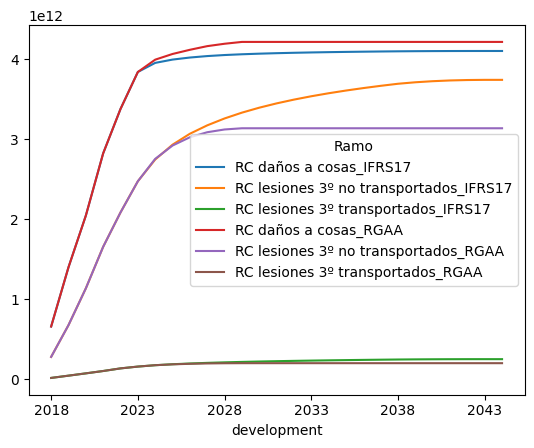

In [33]:
expected_triang_ifrs = pipe_ifrs17.named_steps.model.full_triangle_.dev_to_val().sum('origin').to_frame().T
expected_triang_rgaa = triang_rgaa.named_steps.model.full_triangle_
expected_triang_rgaa.development = [12, 24, 36, 48,60, 72,84]
expected_triang_rgaa = expected_triang_rgaa.dev_to_val().sum('origin').to_frame().T
expected_triang_rgaa.index = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029']
expected_triang_ifrs.merge(expected_triang_rgaa, how = 'left', left_index=True, right_index=True, suffixes=('_IFRS17', '_RGAA')).ffill().plot()

In [34]:
#Importo Curva YTM
curva_ytm = pd.read_excel('bin\\curva_irr_ECL.xlsx')

# Descuento CL IFRS 17
resampled_triangles = pipe_ifrs17.named_steps.model.full_triangle_.cum_to_incr().dev_to_val()
cl_ifrs17 = resampled_triangles.sum('origin').to_frame().T
# #cl_ifrs17 = cl_ifrs17.T.iloc[6:]
cl_ifrs17['Años para el pago'] = np.concatenate((np.zeros(5), np.arange(0, cl_ifrs17.shape[0]-5)))
cl_ifrs17 = cl_ifrs17.merge(curva_ytm, left_on='Años para el pago', right_on='dur', how='left')
cl_ifrs17.index = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042', '2043', '2044']
cl_ifrs17.fillna(0, inplace=True)
cl_ifrs17['RC daños a cosas VP'] = cl_ifrs17.apply(lambda row: row['RC daños a cosas'] / ((1 + row['irr']) ** row['Años para el pago']) , axis=1)
cl_ifrs17['RC lesiones 3º no transportados VP'] = cl_ifrs17.apply(lambda row: row['RC lesiones 3º no transportados'] / ((1 + row['irr']) ** row['Años para el pago']) , axis=1)
cl_ifrs17['RC lesiones 3º transportados VP'] = cl_ifrs17.apply(lambda row: row['RC lesiones 3º transportados'] / ((1 + row['irr']) ** row['Años para el pago']) , axis=1)


In [35]:
df_result_ifrs = cl_ifrs17.loc[:, ['RC daños a cosas', 'RC lesiones 3º no transportados', 'RC lesiones 3º transportados', 'RC daños a cosas VP', 'RC lesiones 3º no transportados VP', 'RC lesiones 3º transportados VP']]
df_result_rgaa = triang_rgaa.named_steps.model.full_triangle_
df_result_rgaa.development = [12, 24, 36, 48,60, 72,84]
df_result_rgaa = df_result_rgaa.cum_to_incr().dev_to_val().sum('origin').to_frame().T
df_result_rgaa.index = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029']
merged_results = df_result_ifrs.merge(df_result_rgaa, how = 'left', left_index=True, right_index=True, suffixes=('_IFRS17', '_RGAA'))
# merged_results_ibnr = merged_results.loc['2024':].sum() / 1000000000
# merged_results_ibnr.to_excel('df_resultados_finales.xlsx')

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
results_to_plot = merged_results.cumsum().ffill()/1000000000



<Axes: xlabel='Años', ylabel='Monto Acumulado'>

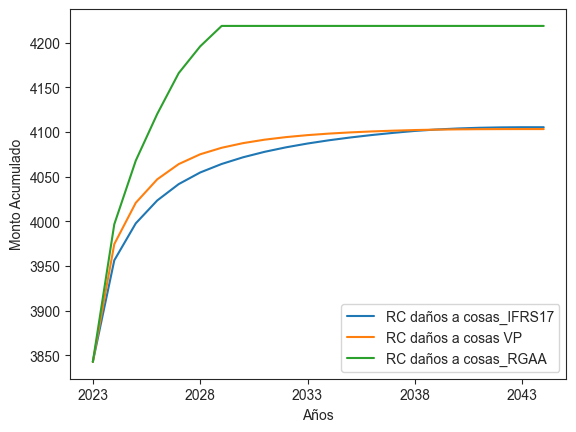

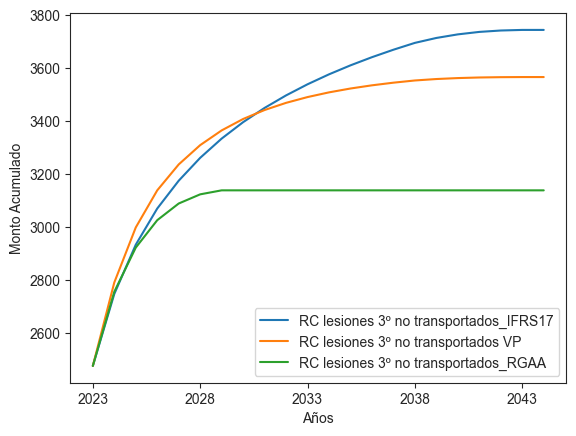

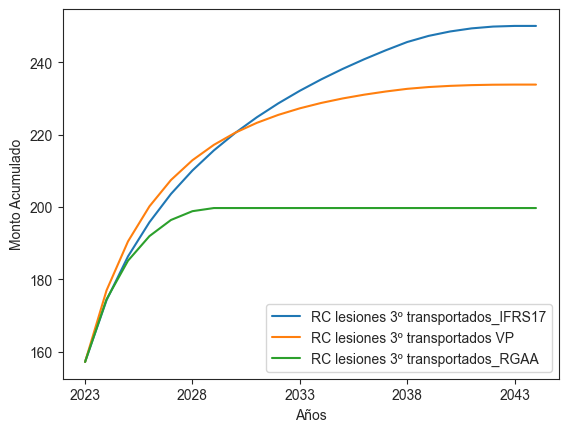

In [37]:
results_to_plot.loc['2023':,['RC daños a cosas_IFRS17','RC daños a cosas VP','RC daños a cosas_RGAA']].plot(xlabel = 'Años', ylabel = 'Monto Acumulado')
results_to_plot.loc['2023':,['RC lesiones 3º no transportados_IFRS17','RC lesiones 3º no transportados VP','RC lesiones 3º no transportados_RGAA']].plot(xlabel = 'Años', ylabel = 'Monto Acumulado')
results_to_plot.loc['2023':,['RC lesiones 3º transportados_IFRS17','RC lesiones 3º transportados VP','RC lesiones 3º transportados_RGAA']].plot(xlabel = 'Años', ylabel = 'Monto Acumulado')

In [38]:
results_to_plot.columns

Index(['RC daños a cosas_IFRS17', 'RC lesiones 3º no transportados_IFRS17',
       'RC lesiones 3º transportados_IFRS17', 'RC daños a cosas VP',
       'RC lesiones 3º no transportados VP', 'RC lesiones 3º transportados VP',
       'RC daños a cosas_RGAA', 'RC lesiones 3º no transportados_RGAA',
       'RC lesiones 3º transportados_RGAA'],
      dtype='object')

In [ ]:
#RA
pipe = cl.Pipeline(
    steps=[
    ('sample', cl.BootstrapODPSample(random_state=23, n_sims=200000)),
    ('dev', cl.Development(average='volume')),
    ('tail', cl.TailCurve('inverse_power', extrap_periods= 15, projection_period=15*12)),
    ('model', cl.Chainladder())])



In [ ]:



pipe.fit(triang_stos_act['Incurridos'].incr_to_cum().iloc[0,0])
resampled_triangles = pipe.named_steps.model.full_triangle_.cum_to_incr().dev_to_val()
resampled_triangles_pv = resampled_triangles.sum('origin') / ((1 + cl_ifrs17['irr']) ** cl_ifrs17['Años para el pago']).values
resampled_triangles_ibnr = resampled_triangles_pv['Incurridos'].iloc[:, 0, 0, 6:].sum('development').to_frame().sort_values()


In [ ]:
resampled_triangles_ibnr[1:-1].mean()

np.float64(425245079241.18524)

In [ ]:
# pd.DataFrame({'Monto simulacion':resampled_triangles_ibnr / 1000000000, 
#                 'ibnr_mean': resampled_triangles_ibnr.mean() / 1000000000}).to_csv(f'var_tvar_ifrs17_rc_autos.csv')

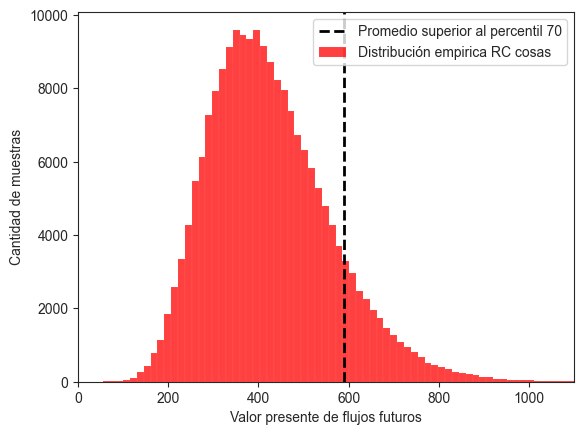

In [122]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

ax = sns.histplot(data = resampled_triangles_ibnr/1000000000, bins = 1000, label = 'Distribución empirica RC cosas', color = 'red')
ax.set_xlim(0,1100)
ax.set_xlabel("Valor presente de flujos futuros")
#ax.set_ylim(0,1100)
ax.set_ylabel("Cantidad de muestras")

percentiles = [70]
colors = ['Black']
for p, c in zip(percentiles, colors):
    ax.axvline(resampled_triangles_ibnr[(resampled_triangles_ibnr >= np.percentile(resampled_triangles_ibnr, p))].mean()/1000000000, color=c, linestyle='--', linewidth=2, label=f'Promedio superior al percentil {p}')

ax.legend()


In [108]:
resampled_triangles_ibnr[(resampled_triangles_ibnr >= np.percentile(resampled_triangles_ibnr, p))].mean()

np.float64(589864224836.5969)

In [ ]:
resampled_triangles_ibnr = resampled_triangles_ibnr[(resampled_triangles_ibnr <= np.percentile(resampled_triangles_ibnr, 99.9)) & (resampled_triangles_ibnr >= np.percentile(resampled_triangles_ibnr, 0.1))]

Ramo
179518    7.540210e+10
20476     7.540228e+10
123781    7.540279e+10
8094      7.540952e+10
142428    7.542104e+10
              ...     
53794     2.158072e+11
117951    2.158112e+11
135168    2.158445e+11
18358     2.158630e+11
69475     2.158932e+11
Length: 197980, dtype: float64

In [ ]:
for i in range(0,3):
    pipe.fit(triang_stos_act['Incurridos'].incr_to_cum().iloc[i,0])
    resampled_triangles = pipe.named_steps.model.full_triangle_.cum_to_incr().dev_to_val()
    resampled_triangles_pv = resampled_triangles.sum('origin') / ((1 + cl_ifrs17['irr']) ** cl_ifrs17['Años para el pago']).values
    resampled_triangles_ibnr = resampled_triangles_pv['Incurridos'].iloc[:, 0, 0, 6:].sum('development').to_frame().sort_values()
    resampled_triangles_ibnr = resampled_triangles_ibnr[(resampled_triangles_ibnr <= np.percentile(resampled_triangles_ibnr, 99.9))]
    pd.DataFrame({'TVar':[(resampled_triangles_ibnr[resampled_triangles_ibnr >= np.percentile(resampled_triangles_ibnr, i)].mean() - resampled_triangles_ibnr.mean()) / 1000000000 for i in range(0, 100, 5)], 
                'Var':[(np.percentile(resampled_triangles_ibnr, i) - resampled_triangles_ibnr.mean()) / 1000000000 for i in range(0, 100, 5)],
                'ibnr_mean': resampled_triangles_ibnr.mean() / 1000000000}).to_excel(f'var_tvar_ifrs17_{i}_2.xlsx')